In [1]:
#Classification of MNIST dataset 
using Gen
using PyPlot
using Distributions
using LinearAlgebra
using Random
using Distances
using Flux
using StatsBase
using MultivariateStats
using MLDatasets
using IterTools #Only for plots, not for program

#include("hmc_mod.jl")
#include("helper_functions.jl")
include("proposals.jl")
include("mnist.jl")
include("utils.jl");

In [2]:
#Load the MNIST Data
num_samples = 10
x_train, y_train = load_mnist_train_set()
x_test, y_test = load_mnist_test_set()

x, y = balanced_set(x_train,y_train,num_samples,2);

#Test Set
x_test, y_test = balanced_set(x_test,y_test,num_samples);

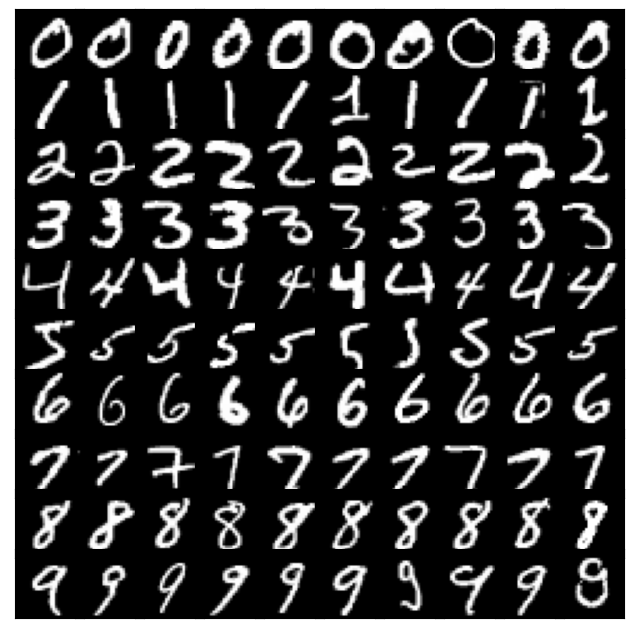

In [3]:
#Visualize Samples
x_reshaped = reshape_x(x)

nrow, ncol = 10,num_samples 
fig = figure("plot_mnist",figsize=(6,6))
for (i, (c, r)) in enumerate(Iterators.product(1:ncol, 1:nrow))
    subplot(nrow, ncol, i)
    imshow(x_reshaped[:,:,i]', cmap="gray")
    ax = gca()
    ax.xaxis.set_visible(false)
    ax.yaxis.set_visible(false)
end;
tight_layout(w_pad=-1, h_pad=-1, pad=-0.5);

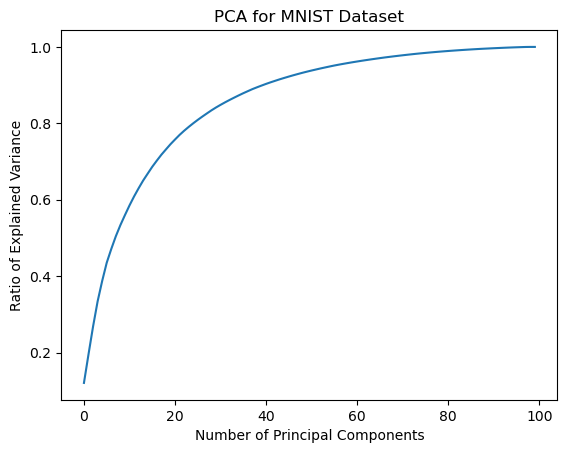

In [4]:
#Run PCA to lower dimensionality of MNIST
vars = []
x = transpose(x)
for i=1:100    
    MNIST_PCA = fit(PCA, x, maxoutdim=i, pratio=1.0)
    push!(vars,MNIST_PCA.tprinvar/MNIST_PCA.tvar)
end
plot(vars)
plt.title("PCA for MNIST Dataset")
plt.xlabel("Number of Principal Components")
plt.ylabel("Ratio of Explained Variance");

In [228]:
#Get PCA Transform for x
dims = 25
x_pca = fit(PCA,x,maxoutdim=dims)
xt = transform(x_pca,x)

#Testing PCA Transform
xz = transform(x_pca,transpose(x_test));

In [229]:
#One-Hot Encode Y
yt = Flux.onehotbatch(y,[:1,:2,:3,:4,:5,:6,:7,:8,:9,:10]);

#Test Set
yz = y_test
yzt = Flux.onehotbatch(yz,[:1,:2,:3,:4,:5,:6,:7,:8,:9,:10]);

In [230]:
#------------------------------------
#Hyperparameters and Helper Functions
#------------------------------------

#Select Network Goal
network = "classifier"

#Data hyperparameters
n = num_samples #Number of samples
c = 10 #Number of classes
d = dims #Input dimension
N = n*c #Total samples

#Network hyperparameters
α₁ = 1 #Input Weights, Biases Shape
β₁ = 1 #Input Weights, Biases Scale/Rate
α₂ = 1 #Hidden & Output Weights Shape

#Node hyperparameters
k_range = 20 #Maximum number of neurons per layer
k_list = [Int(i) for i in 1:k_range]

#NUTS
Δ_max = 1000;

In [231]:
#New Softmax
function softmax_(arr::AbstractArray)
    ex = mapslices(x -> exp.(0.1.*x),arr,dims=1)
    rows, cols = size(arr)
    val = similar(ex)
    for i in 1:cols
        s = sum(ex[:,i])
        for j in 1:rows
            val[j,i] = ex[j,i]/s
        end
    end
    return val
end;

In [232]:
#Bayesian Neural Net
function G(x, trace)
    activation = relu
    layers = trace[:l]
    ks = [trace[(:k,i)] for i=1:layers]
    
    for i=1:layers
        in_dim, out_dim = layer_unpacker(i, layers, ks)
        W = reshape(trace[(:W,i)], out_dim, in_dim)
        b = reshape(trace[(:b,i)], trace[(:k,i)])
        nn = Dense(W, b, activation)
        x = nn(x)
    end
    
    Wₒ = reshape(trace[(:W,layers+1)], c, ks[layers])
    bₒ = reshape(trace[(:b,layers+1)], c)
    
    nn_out = Dense(Wₒ, bₒ)
    x = nn_out(x)
    
    return softmax_(x)
end;

In [233]:
@gen function classifier(x::Array{Float64})
    
    #Create a blank choicemap
    obs = choicemap()::ChoiceMap
    
    #Draw number of layers - 1 for Classifier Net
    l ~ categorical([1.0])
    l_real = l
    obs[:l] = l
    
    #Create individual weight and bias vectors
    #Loop through hidden layers
    k = [Int(0) for i=1:l+1]
    for i=1:l
        k[i] = @trace(categorical([1/length(k_list) for i=1:length(k_list)]), (:k,i))
        obs[(:k,i)] = k[i]
    end
    output_array = zeros(Float64, 10)
    output_array[10] = 1.0

    k[l+1] = @trace(categorical(output_array), (:k,l+1))
    obs[(:k,l+1)] = k[l+1]
    
    ##################################################
    #Adapted from BH: hyperparameter schedule - Apr 3#
    ##################################################
    
    α₁ = 1 #Input Weights, Biases Shape
    β₁ = 1 #Input Weights, Biases Scale/Rate
    α₂ = 1 #Hidden & Output Weights Shape
    β₂ = k[1] #Scale Hyperparameter Based on Number of Nodes
    
    τ = [0.0 for i=1:l+1]
    τᵦ = [0.0 for i=1:l+1]
    σ = [0.0 for i=1:l+1]
    σᵦ = [0.0 for i=1:l+1]
    
    for i=1:l+1
        if i==1
            τ[i] = @trace(gamma(α₁,β₁), (:τ,i))
            τᵦ[i] = @trace(gamma(α₁,β₁), (:τᵦ,i))
        else
            τ[i] = @trace(gamma(α₂,β₂), (:τ,i))
            τᵦ[i] = @trace(gamma(α₁,β₁), (:τᵦ,i))
        end
        σ[i] = 1/τ[i]
        σᵦ[i] = 1/τᵦ[i]
    end
    
    #Sample weight and bias vectors
    W = [zeros(k[i]) for i=1:l+1]
    b = [zeros(k[i]) for i=1:l+1]

    for i=1:l+1
        if i == 1
            h = Int(d * k[i])
        else
            h = Int(k[i-1] * k[i])
        end

        if i<=l
            #Hidden Weights
            u = zeros(h)
            S = Diagonal([σ[i] for j=1:length(u)])
            W[i] = @trace(mvnormal(u,S), (:W,i))
            obs[(:W,i)] = W[i]
            
            #Hidden Biases
            ub = zeros(k[i])
            Sb = Diagonal([σᵦ[i] for j=1:length(ub)])   
            b[i] = @trace(mvnormal(ub,Sb), (:b,i))
            obs[(:b,i)] = b[i]
        else
            #Output Weights
            u = zeros(h)
            S = Diagonal([σ[i] for j=1:length(u)])
            W[i] = @trace(mvnormal(u,S), (:W,i))
            obs[(:W,i)] = W[i]

            #Output Bias
            ub = zeros(10)
            Sb = Diagonal([σᵦ[i] for j=1:length(ub)]) 
            b[i] = @trace(mvnormal(ub,Sb), (:b,i))
            obs[(:b,i)] = b[i]
        end
    end
    
    #Return Network Scores for X
    scores = G(x,obs)
    
    #Logistic Classification Likelihood
    y = zeros(length(scores))
    for j=1:length(x[1,:])
        score_vec = scores[:,j]
        #println(score_vec)
        y[j] = @trace(categorical(score_vec), (:y,j))
    end
    
    return scores
    
end;

obs_master = choicemap()::ChoiceMap
for i=1:length(y)
    obs_master[(:y,i)] = y[i]
end
obs = obs_master;

(best_trace,) = generate(classifier, (xt,), obs)
println(get_score(best_trace))
println(best_trace[(:k,1)])
test_labels = G(xt,best_trace)
results = label_output(test_labels)
test_acc = sum([y[i] == results[i] for i=1:length(y)])

-589.7133213300938
7


7

In [234]:
test_labels[:,1]

10-element Array{Float64,1}:
 0.0712092550561592
 0.05723491438564173
 0.16210153558731633
 0.03194179577279167
 0.28134511907639675
 0.05183600559593531
 0.04807158656573753
 0.12941693269297183
 0.055483842232013705
 0.1113590130350359

In [235]:
include("proposals.jl")
obs[(:k,1)] = 1
(best_trace,) = generate(classifier, (xt,), obs)
new_trace,q = node_birth(best_trace)
display(reshape(best_trace[(:W,1)], best_trace[(:k,1)], d))
display(reshape(new_trace[(:W,1)], new_trace[(:k,1)], d))
println(get_score(best_trace))
println(get_score(new_trace))

test_labels = G(xt,best_trace)
results = label_output(test_labels)
test_acc = sum([y[i] == results[i] for i=1:length(y)])
println("Old trace Accuracy: $test_acc")

test_labels = G(xt,new_trace)
results = label_output(test_labels)
test_acc = sum([y[i] == results[i] for i=1:length(y)])
println("New trace Accuracy: $test_acc")

1×25 Array{Float64,2}:
 -2.3613  -4.19132  -0.646656  0.933101  …  5.56916  0.639616  0.938694

2×25 Array{Float64,2}:
 -15.5103   6.9957   -17.4121    3.55459   …  -0.0896475  -8.89816   1.85773
  -2.3613  -4.19132   -0.646656  0.933101      5.56916     0.639616  0.938694

-339.0899202866038
-648.1540824262262
Old trace Accuracy: 16
New trace Accuracy: 14


In [236]:
include("proposals.jl")

println("Current k: $(best_trace[(:k,1)])")
new_trace2,q = node_death(new_trace)
display(reshape(new_trace[(:W,1)], new_trace[(:k,1)], d))
display(reshape(new_trace2[(:W,1)], new_trace2[(:k,1)], d))
println(get_score(new_trace))
println(get_score(new_trace2))

test_labels = G(xt,new_trace)
results = label_output(test_labels)
test_acc = sum([y[i] == results[i] for i=1:length(y)])
println("Old trace Accuracy: $test_acc")

test_labels = G(xt,new_trace2)
results = label_output(test_labels)
test_acc = sum([y[i] == results[i] for i=1:length(y)])
println("New trace Accuracy: $test_acc")

2×25 Array{Float64,2}:
 -15.5103   6.9957   -17.4121    3.55459   …  -0.0896475  -8.89816   1.85773
  -2.3613  -4.19132   -0.646656  0.933101      5.56916     0.639616  0.938694

1×25 Array{Float64,2}:
 -2.3613  -4.19132  -0.646656  0.933101  …  5.56916  0.639616  0.938694

Current k: 1
-648.1540824262262
-339.0899202866038
Old trace Accuracy: 14
New trace Accuracy: 16


In [237]:
display(reshape(new_trace[(:W,2)],new_trace[(:k,2)],new_trace[(:k,1)]))
display(reshape(new_trace2[(:W,2)],new_trace2[(:k,2)],new_trace2[(:k,1)]))

10×2 Array{Float64,2}:
 -0.732579   -0.427358
  0.392284    0.880752
  0.138355   -1.10884
  0.315995   -1.19718
  0.474388   -0.259376
  0.183122   -0.0102441
 -1.33657     0.220162
 -0.303138   -0.150571
  0.0557555   0.0174785
  0.440468    0.986939

10×1 Array{Float64,2}:
 -0.42735752955979417
  0.8807523020752082
 -1.108841695429195
 -1.1971774489197395
 -0.25937636322482793
 -0.010244092805777434
  0.2201616038386048
 -0.1505705808761578
  0.017478489876208134
  0.9869385388622319

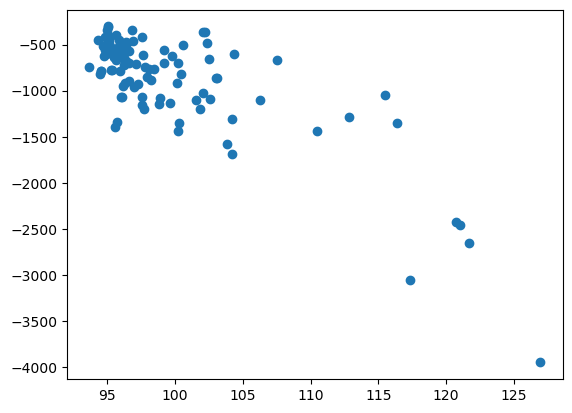

Any[15, 11, 11, 13, 20, 2, 11, 20, 19, 8, 17, 11, 14, 20, 2, 6, 13, 11, 9, 1, 12, 6, 9, 3, 6, 1, 8, 10, 15, 18, 20, 3, 16, 7, 1, 11, 9, 10, 4, 10, 18, 8, 6, 12, 12, 5, 8, 9, 1, 17, 15, 4, 6, 11, 10, 13, 8, 18, 12, 2, 9, 19, 1, 10, 2, 3, 8, 5, 8, 20, 16, 3, 8, 3, 19, 18, 8, 6, 11, 16, 3, 7, 19, 20, 15, 10, 8, 11, 14, 16, 8, 16, 20, 20, 7, 3, 13, 10, 7, 15]


In [239]:
#Test Likelihood
obs_master = choicemap()::ChoiceMap
for i=1:length(y)
    obs_master[(:y,i)] = y[i]
end
obs = obs_master;

scores = []
accs = []
ks = []
for i = 1:100
    (trace,) = generate(classifier, (xt,), obs)
    push!(ks,trace[(:k,1)])
    push!(scores,get_score(trace))
    test_labels = G(xt,trace)
    results = label_output(test_labels)
    test_acc = sum([y[i] == results[i] for i=1:length(y)])/length(y)
    test_acc = sum([euclidean(yt[:,j],test_labels[:,j]) for j=1:length(y)])
    push!(accs,test_acc)
end

scatter(accs,scores)
#plt.ylim(-2000,0)
println(ks)

In [240]:
include("NUTS.jl")
(best_trace,) = generate(classifier, (xt,), obs)
l = best_trace[:l]
param_selection = select()
for i=1:l+1 #Number of Layers
    push!(param_selection, (:W,i))
    push!(param_selection, (:b,i))
end
traces = NUTS(best_trace, param_selection, 0.65, 100, 3, true);

[NUTS] start sampling for 100 samples with inital ϵ=2.0
....................................................................................................
[NUTS] sampling complete with final apated ϵ = 0.872577338055807


In [246]:
#Straight NUTS
include("NUTS.jl")
Δ_max = 100

@gen function gibbs_hyperparameters(trace)
    obs_new = choicemap()::ChoiceMap
    args = get_args(trace)
    argdiffs = map((_) -> NoChange(), args)
    
    for i=1:trace[:l] + 1
        #Biases
        bias = trace[(:b,i)]
        
        n = length(bias)
        α = α₁ + (n/2)
        
        Σ = sum(bias.^2)/2 
        β = 1/(1/β₁ + Σ)
        
        τᵦ ~ gamma(α,β)
        
        #Weights
        β₂ = trace[(:k,1)]
        
        i == 1 ? α₀ = α₁ : α₀ = α₂
        i == 1 ? β₀ = β₁ : β₀ = β₂
        
        weight = trace[(:W,i)]
        
        n = length(weight)
        α = α₀ + (n/2)
        
        Σ = sum(weight.^2)/2
        β = 1/(1/β₀ + Σ)
        
        τ ~ gamma(α,β)
        
        obs_new[(:τ,i)] = τ
        obs_new[(:τᵦ,i)] = τᵦ
    end
    
    (new_trace,_,_,_) = update(trace, args, argdiffs, obs_new)
    
    return new_trace
end

m=1
iters=1000

(best_trace,) = generate(classifier, (xt,), obs)
best_k = best_trace[(:k,1)]
println("Starting ks: $best_k")
traces = []
push!(traces,best_trace)

function nuts_parameters(trace)
    
    l = trace[:l]
    param_selection = select()
    for i=1:l+1 #Number of Layers
        push!(param_selection, (:W,i))
        push!(param_selection, (:b,i))
    end
    
    prev_score = get_score(trace)
    
    acc = 0
    for i=1:1
        new_trace = NUTS(trace, param_selection, 0.65, m, m, false)[m+1]
        new_score = get_score(new_trace)
        if prev_score != new_score
            println("Accepted")
            return (new_trace, 1)
        else
            return (trace, 0)
        end
    end
    
    return (trace, acc)
end

for i=1:iters
    
    trace_star = traces[i]
    if i%10 == 0
        println("Iteration $i: $(get_score(trace_star))")
        flush(stdout)
    end
    trace_star = gibbs_hyperparameters(trace_star)
    trace_star, accepted = nuts_parameters(trace_star)

    push!(traces,trace_star)
end

Starting ks: 3
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Iteration 10: -405.0764261552982
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Iteration 20: -400.1047219442267
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Iteration 30: -401.24391153033116
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Iteration 40: -396.6088219510289
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Iteration 50: -397.8514402317918
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Iteration 60: -399.28661755415834
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Iteration 70: -393.17184366901347
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Iteration 80: -395.8362210286307
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Accepted
Iteration 90: -406.6779129019665
Accepted
A

InterruptException: InterruptException:

In [257]:
#-------------
#Run Inference
#-------------

include("NUTS.jl")
Δ_max = 1
acc_prob = 0.65
#Random.seed!(1)

scores = []
traces = []
ks = []
across_acceptance = []
within_acceptance = []

#Inference Hyperparameters
across_iters = 1
m = 1

@gen function gibbs_hyperparameters(trace)
    obs_new = choicemap()::ChoiceMap
    args = get_args(trace)
    argdiffs = map((_) -> NoChange(), args)
    
    for i=1:trace[:l] + 1
        #Biases
        bias = trace[(:b,i)]
        
        n = length(bias)
        α = α₁ + (n/2)
        
        Σ = sum(bias.^2)/2 
        β = 1/(1/β₁ + Σ)
        
        τᵦ ~ gamma(α,β)
        
        #Weights
        β₂ = trace[(:k,1)]
        
        i == 1 ? α₀ = α₁ : α₀ = α₂
        i == 1 ? β₀ = β₁ : β₀ = β₂
        
        weight = trace[(:W,i)]
        
        n = length(weight)
        α = α₀ + (n/2)
        
        Σ = sum(weight.^2)/2
        β = 1/(1/β₀ + Σ)
        
        τ ~ gamma(α,β)
        
        obs_new[(:τ,i)] = τ
        obs_new[(:τᵦ,i)] = τᵦ
    end
    
    (new_trace,_,_,_) = update(trace, args, argdiffs, obs_new)
    
    return new_trace
end

function nuts_parameters(trace)
    
    l = trace[:l]
    param_selection = select()
    for i=1:l+1 #Number of Layers
        push!(param_selection, (:W,i))
        push!(param_selection, (:b,i))
    end
    
    prev_score = get_score(trace)
    
    acc = 0
    for i=1:1
        new_trace = NUTS(trace, param_selection, 0.65, m, m, false)[m+1]
        new_score = get_score(new_trace)
        if prev_score != new_score
            #println("Accepted")
            return (new_trace, 1)
        else
            return (trace, 0)
        end
    end
    
    return (trace, acc)
end

function node_parameter(trace)
    obs = obs_master
    for i=1:trace[:l]+1
        obs[(:τ,i)] = trace[(:τ,i)]
        obs[(:τᵦ,i)] = trace[(:τᵦ,i)]
    end
    
    init_trace = trace
    
    #################################################RJNUTS#################################################
    #NUTS Step 1
    trace_tilde = trace
    for i=1:across_iters
        trace_tilde = gibbs_hyperparameters(trace_tilde)
        (trace_tilde,) = nuts_parameters(trace_tilde)
    end
    
    #Reversible Jump Step
    (trace_prime, q_weight) = node_change(trace_tilde)
    
    #NUTS Step 2
    trace_star = trace_prime
    for i=1:across_iters
        (trace_star,) = nuts_parameters(trace_star)
        trace_star = gibbs_hyperparameters(trace_star)
    end
    #################################################RJNUTS#################################################
        
    model_score = -get_score(init_trace) + get_score(trace_star)
    across_score = model_score + q_weight

    if rand() < exp(across_score)
        println("********** Accepted: $(trace_star[(:k,1)]) **********")
        return (trace_star, 1)
    else
        return (init_trace, 0)
    end
end

obs_master = choicemap()::ChoiceMap
for i=1:length(y)
    obs_master[(:y,i)] = y[i]
end
obs = obs_master;

(trace,) = generate(classifier, (xt,), obs)
#trace = best_trace
starting_k = trace[(:k,1)]
println("Starting k: $starting_k")
traces = []

for i=1:300
    (trace, accepted) = node_parameter(trace)
    push!(across_acceptance, accepted)
    trace  = gibbs_hyperparameters(trace)
    (trace, accepted) = nuts_parameters(trace)
    push!(within_acceptance, accepted)
    push!(scores,get_score(trace))
    push!(traces, trace)
    println("$i : $(get_score(trace))")
    flush(stdout)
    if i%10 == 0
        a_acc = 100*(sum(across_acceptance)/length(across_acceptance))
        w_acc = 100*(sum(within_acceptance)/length(within_acceptance))
        println("Epoch $i A Acceptance Probability: $a_acc %")
        println("Epoch $i W Acceptance Probability: $w_acc %")
    end
end

Starting k: 5
1 : -498.4963941983875
********** Accepted: 4 **********
2 : -447.74437121809814
3 : -448.5566422581238
4 : -446.0876215388866
5 : -439.9365035276334
6 : -442.382217641386
7 : -439.65883938542964
8 : -441.65977197732326
9 : -441.8122123727799
10 : -446.2129594919985
Epoch 10 A Acceptance Probability: 10.0 %
Epoch 10 W Acceptance Probability: 60.0 %
********** Accepted: 5 **********
11 : -494.42969781285484
12 : -497.1858276091006
********** Accepted: 4 **********
13 : -439.9909024855879
14 : -439.04425090386167
15 : -438.9049679446533
********** Accepted: 5 **********
16 : -496.7227738321561
17 : -493.4117069762667
18 : -496.461863274945
********** Accepted: 4 **********
19 : -444.2863628249985
20 : -438.01821418220453
Epoch 20 A Acceptance Probability: 25.0 %
Epoch 20 W Acceptance Probability: 60.0 %
21 : -439.0493601057457
22 : -437.6486204847545
23 : -437.28859767653466
24 : -440.56709698734755
25 : -436.0157039269526
26 : -437.4310915483778
27 : -437.9769416734447
28 

218 : -549.2895799253414
219 : -549.0296562386818
220 : -546.8738989903808
Epoch 220 A Acceptance Probability: 10.0 %
Epoch 220 W Acceptance Probability: 62.272727272727266 %
********** Accepted: 6 **********
221 : -510.58107803789255
222 : -512.1496593341426
223 : -506.52687378206423
224 : -506.97064784651707
225 : -508.6284727354592
226 : -512.361179486887
227 : -506.3445757364255
228 : -504.79661206805133
229 : -502.25586349957746
230 : -504.44565141553534
Epoch 230 A Acceptance Probability: 10.0 %
Epoch 230 W Acceptance Probability: 63.04347826086957 %
231 : -501.7150476573549
232 : -503.6888805890869
233 : -501.26103195541026
234 : -501.0840451602906
235 : -500.97258159198685
236 : -499.9592971770126
237 : -500.3002722215014
238 : -500.6741994741691
239 : -500.75348092129235
240 : -498.96920576185687
Epoch 240 A Acceptance Probability: 9.583333333333334 %
Epoch 240 W Acceptance Probability: 62.5 %
241 : -500.61212223487087
242 : -500.76509940083025
243 : -499.24249921349906
244 : 

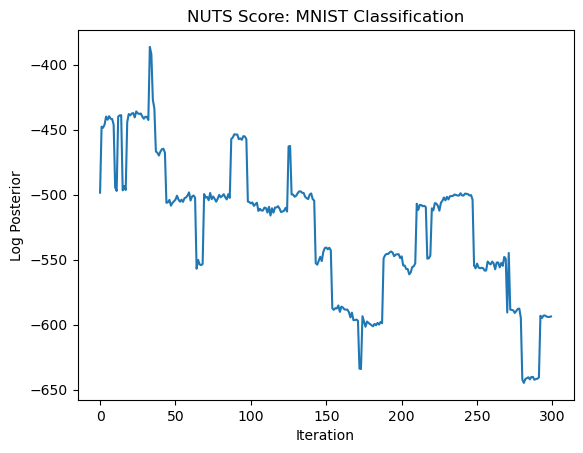

In [258]:
#Log Posterior Score Chart
obs_master = choicemap()::ChoiceMap
for i=1:length(y)
    obs_master[(:y,i)] = y[i]
end
obs = obs_master;

plot([get_score(trace) for trace in traces])
plt.title("NUTS Score: MNIST Classification")
plt.xlabel("Iteration")
plt.ylabel("Log Posterior");

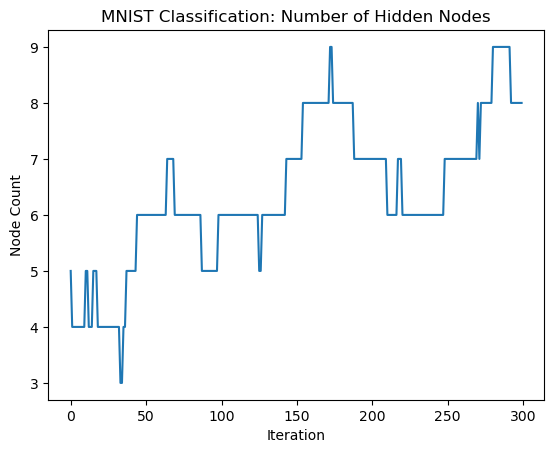

In [259]:
#Node Count Chart

plot([trace[(:k,1)] for trace in traces])
plt.title("MNIST Classification: Number of Hidden Nodes")
plt.xlabel("Iteration")
plt.ylabel("Node Count");

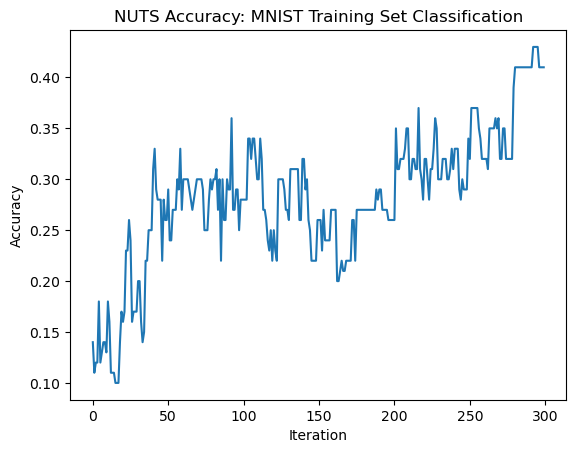

In [260]:
#Plot Training Accuracy
accs = []
dists = []
for i = 1:length(traces)
    trace = traces[i]
    test_labels = G(xt,trace)
    results = label_output(test_labels)
    test_acc = sum([y[i] == results[i] for i=1:length(y)])/length(y)
    test_dist = sum([euclidean(yt[:,j],test_labels[:,j]) for j=1:length(y)])
    push!(accs,test_acc)
    push!(dists,test_dist)
end

plot(accs)
plt.title("NUTS Accuracy: MNIST Training Set Classification")
plt.xlabel("Iteration")
plt.ylabel("Accuracy");

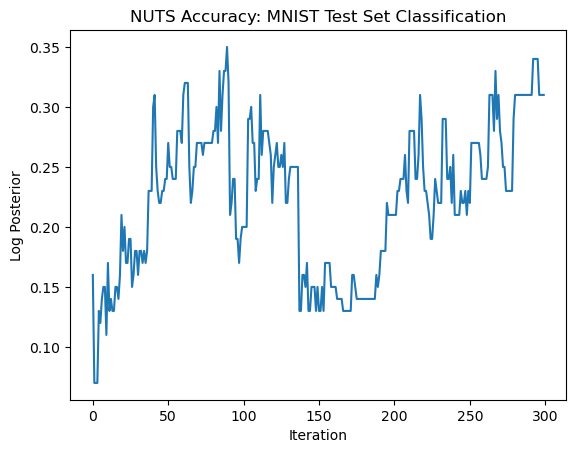

In [261]:
#Plot Testing Accuracy
accs = []
#dists = []
for i = 1:length(traces)
    trace = traces[i]
    test_labels = G(xz,trace)
    results = label_output(test_labels)
    test_acc = sum([y_test[i] == results[i] for i=1:length(y_test)])/length(y_test)
    test_dist = sum([euclidean(yzt[:,j],test_labels[:,j]) for j=1:length(y)])
    push!(accs,test_acc)
    #push!(dists,test_dist)
end

plot(accs)
plt.title("NUTS Accuracy: MNIST Test Set Classification")
plt.xlabel("Iteration")
plt.ylabel("Log Posterior");

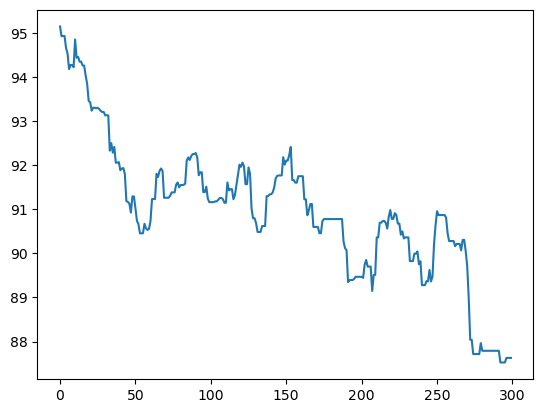

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f70fe72a110>

In [262]:
plot(dists)

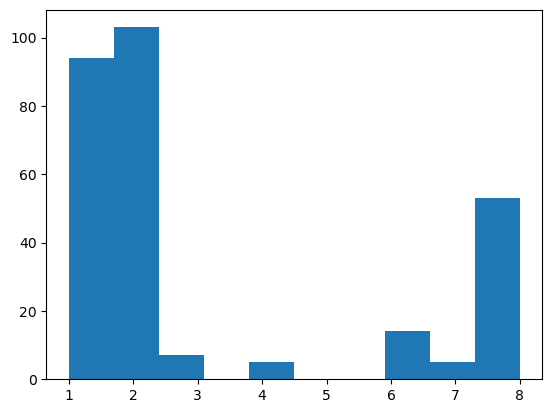

Any[1, 1, 1, 1, 1, 1, 1, 7, 1, 1, 1, 6, 7, 7, 7, 7, 6, 6, 6, 6, 6, 2, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 2, 4, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 3, 3, 3, 3, 3, 2, 2, 3, 2, 2, 2, 2, 6, 6, 6, 6, 6, 6, 8, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 6, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
1


In [263]:
y[1]
targets = []
target = 10
for i=20:length(traces)
    trace = traces[i]
    test_labels = G(xt,trace)
    results = label_output(test_labels)
    push!(targets,results[target])
end
hist(targets)
println(targets)
println(y[target])

In [264]:
#Marginalize Probabilities - Train Set
j = 1
targets = zeros(length(traces)-j,c,N)
for i=j:length(traces)-j
    trace = traces[i]
    labels = G(xt,trace)
    targets[i-j+1,:,:] = labels
end

sums = sum(targets,dims=1)[1,:,:]./(length(traces)-j)
guesses = [findmax(sums[:,i])[2] for i=1:N]
test_acc = sum([y[i] == guesses[i] for i=1:length(y)])

41

In [265]:
#Marginalize Probabilities - Test Set
j = 1
targets = zeros(length(traces)-j,c,N)
for i=j:length(traces)-j
    trace = traces[i]
    labels = G(xz,trace)
    targets[i-j+1,:,:] = labels
end

sums = sum(targets,dims=1)[1,:,:]./(length(traces)-j)
guesses = [findmax(sums[:,i])[2] for i=1:N]
test_acc = sum([yz[i] == guesses[i] for i=1:length(yz)])

31